In [46]:
import serial
import time
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# pinch pressure


/home/ubuntu/miniconda3/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


0.06796093927583019
0.9946750918170459


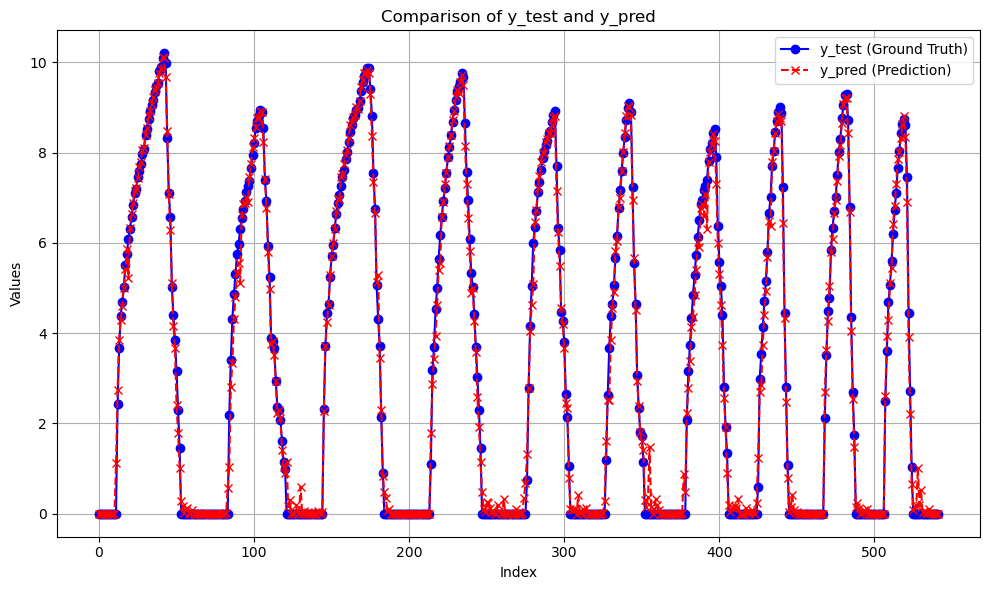

In [77]:
import numpy as np


def analyze_txt_and_predict_force(model_file_path, read_file_path, write_file_name, write_file_path_root, frame_interval, window_size, force_threshold):
    if frame_interval <= window_size:
        return analyze_txt_and_predict_force_overlap(model_file_path, read_file_path, write_file_name, write_file_path_root, frame_interval, window_size, force_threshold)
    else:
        return analyze_txt_and_predict_force_nonOverlap(model_file_path, read_file_path, write_file_name, write_file_path_root, frame_interval, window_size, force_threshold)
def analyze_txt_and_predict_force_overlap(model_file_path, read_file_path, write_file_name, write_file_path_root, frame_interval, frames_to_extract, force_threshold):
    def normalize(raw_data):
        mean = np.mean(raw_data, axis=0)
        std = np.std(raw_data, axis=0)
        normalized_data = (raw_data - mean) / (std + 1e-6)
        return normalized_data
    model = joblib.load(model_file_path)

    # Temporary lists to hold data before packing into the main lists (as a queue)
    temp_real_queue = []
    temp_imaginary_queue = []
    temp_force_queue = []

    y_test = []
    y_pred = []
    x_test_list = []
    x_test_list_preNormalize = []
    if not os.path.exists(write_file_path_root):
        os.makedirs(write_file_path_root)
    write_file_path = os.path.join(write_file_path_root, write_file_name)
    with open(write_file_path, 'w') as f:
        with open(read_file_path, 'r') as file:
            frame_count = 0  # To track the total number of frames processed
            extracting_frames = False  # Flag to indicate if we are in an extraction block
            lines_in_frame = 0  # To count lines within a frame block
            predict_size = 0

            for line in file:
                line = line.strip()

                # Detect the start of a new frame
                if line == "frame":
                    frame_count += 1
                    lines_in_frame = 0  # Reset line count for the new frame
                    extracting_frames = True  # Always extracting frames

                # If we're extracting frames, process the next 3 lines
                if extracting_frames:
                    if lines_in_frame == 1:  # First data line (real values)
                        temp_real_queue.append([float(num) for num in line.split()])
                    elif lines_in_frame == 2:  # Second data line (imaginary values)
                        temp_imaginary_queue.append([float(num) for num in line.split()])
                    elif lines_in_frame == 3:  # Third data line (force values)
                        force_value = float(line.split()[0])  # Extract the first value (force)
                        temp_force_queue.append(force_value)

                        # If the queue length reaches frames_to_extract, perform prediction
                        if len(temp_real_queue) == frames_to_extract:
                            # Convert queue data to numpy arrays
                            np_real_list = np.array(temp_real_queue)
                            np_imaginary_list = np.array(temp_imaginary_queue)
                            np_force_list = np.array(temp_force_queue)
                            np_force_mean_value = np.mean(np_force_list)
                            if np_force_mean_value < force_threshold:
                                np_force_mean_value = 0
                            # Combine real and imaginary parts
                            combined_12 = np.concatenate((np_real_list, np_imaginary_list), axis=1)
                            # combined_12 = np.expand_dims(combined_12, axis=0)
                            x_test_list_preNormalize.append(combined_12)
                            # combined_12 = normalize(combined_12)
                            x_test_list.append(combined_12)
                            X_test = combined_12.reshape(1, frames_to_extract * 12)
                            # Perform prediction
                            predictions = model.predict(X_test)
                            predict_size += 1

                            y_pred.append(predictions[0])
                            y_test.append(np_force_mean_value)
                            # Write results to file
                            f.write(f"Predict {predict_size}: \n")
                            f.write(f"{np_force_mean_value}\n")
                            f.write(f"{predictions[0]}\n")

                            # Remove the oldest frame to allow overlap
                            for delete in range(frame_interval):
                                temp_real_queue.pop(0)
                                temp_imaginary_queue.pop(0)
                                temp_force_queue.pop(0)

                # Count lines within a frame block
                if extracting_frames:
                    lines_in_frame += 1
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    y_pred_write_file_path = os.path.join(write_file_path_root, "y_pred")
    np.save(y_pred_write_file_path, y_pred)
    y_test_write_file_path = os.path.join(write_file_path_root, "y_test")
    np.save(y_test_write_file_path, y_test)
    return y_pred, y_test, np.array(x_test_list), np.array(x_test_list_preNormalize)
def analyze_txt_and_predict_force_nonOverlap(model_file_path, read_file_path, write_file_name, write_file_path_root, frame_interval, window_size, force_threshold):
    def normalize(raw_data):
        mean = np.mean(raw_data, axis=0)
        std = np.std(raw_data, axis=0)
        normalized_data = (raw_data - mean) / (std + 1e-6)
        return normalized_data
    model = joblib.load(model_file_path)
    y_test = []
    y_pred = []
    x_test_list = []
    x_test_list_preNormalize = []
    if not os.path.exists(write_file_path_root):
        os.makedirs(write_file_path_root)
    write_file_path = os.path.join(write_file_path_root, write_file_name)
    with open(write_file_path, 'w') as f:
        frame_count = 0  # To track the total number of frames processed
        extracting_frames = False  # Flag to indicate if we are in an extraction block
        lines_in_frame = 0  # To count lines within a frame block
        predict_size = 0
        # while True:
        with open(read_file_path, 'r') as file:
            for line in file:
                # line = ser.readline().decode()
                line = line.strip()

                # Detect the start of a new frame
                if line == "frame":
                    frame_count += 1
                    lines_in_frame = 0  # Reset line count for the new frame

                    # Check if it's time to start extracting frames
                    if frame_count % frame_interval == 0:
                        extracting_frames = True
                        frames_extracted = 0  # Reset the number of extracted frames for this block
                        temp_real_list = []  # Clear temp lists for this extraction block
                        temp_imaginary_list = []
                        temp_force_list = []

                # If we're extracting frames, process the next 3 lines
                if extracting_frames:
                    if lines_in_frame == 1:  # First data line (real values)
                        temp_real_list.append([float(num) for num in line.split()])
                    elif lines_in_frame == 2:  # Second data line (imaginary values)
                        temp_imaginary_list.append([float(num) for num in line.split()])
                    elif lines_in_frame == 3:  # Third data line (force values)
                        force_value = float(line.split()[0])  # Extract the first value (force)
                        temp_force_list.append(force_value)
                        frames_extracted += 1  # Increment frames extracted count


                        # If we have extracted enough frames (frames_to_extract), store them
                        if frames_extracted == window_size:
                            # Convert queue data to numpy arrays
                            np_real_list = np.array(temp_real_list)
                            np_imaginary_list = np.array(temp_imaginary_list)
                            np_force_list = np.array(temp_force_list)
                            np_force_mean_value = np.mean(np_force_list)
                            if np_force_mean_value < force_threshold:
                                np_force_mean_value = 0
                            # Combine real and imaginary parts
                            combined_12 = np.concatenate((np_real_list, np_imaginary_list), axis=1)
                            # combined_12 = np.expand_dims(combined_12, axis=0)
                            x_test_list_preNormalize.append(combined_12)
                            # combined_12 = normalize(combined_12)
                            x_test_list.append(combined_12)
                            X_test = combined_12.reshape(1, window_size * 12)
                            # Perform prediction
                            predictions = model.predict(X_test)
                            predict_size += 1

                            y_pred.append(predictions[0])
                            y_test.append(np_force_mean_value)
                            # Write results to file
                            f.write(f"Predict {predict_size}: \n")
                            f.write(f"{np_force_mean_value}\n")
                            f.write(f"{predictions[0]}\n")
                            extracting_frames = False  # Stop extracting for this interval

                # Count lines within a frame block
                if extracting_frames:
                    lines_in_frame += 1
        # ser.close()
    f.close()
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    y_pred_write_file_path = os.path.join(write_file_path_root, "y_pred")
    np.save(y_pred_write_file_path, y_pred)
    y_test_write_file_path = os.path.join(write_file_path_root, "y_test")
    np.save(y_test_write_file_path, y_test)
    return y_pred, y_test, np.array(x_test_list), np.array(x_test_list_preNormalize)

read_file_path = "/home/ubuntu/paper_arm_model/EIT_Model_Input_Resource/pinch-pressure/batch-2/p33-50kHz-1mA-6m-1.txt"
model_file_path = '/home/ubuntu/paper_arm_model/best_model/best_rf_model.joblib'
write_file_name = "predict_result_and_ground_truth.txt"
write_file_path_root = "/home/ubuntu/paper_arm_model/best_model_result/test3"
frame_interval = 20  # Number of frames to skip between extractions
window_size = 10  # Number of frames to extract after the interval
force_threshold = 0.5

y_pred, y_test, x_test_list, x_test_list_preNormalize = analyze_txt_and_predict_force(model_file_path, read_file_path, write_file_name, write_file_path_root, frame_interval, window_size, force_threshold)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)
print(r2)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='y_test (Ground Truth)', marker='o', linestyle='-', color='blue')
plt.plot(y_pred, label='y_pred (Prediction)', marker='x', linestyle='--', color='red')


plt.title('Comparison of y_test and y_pred')
plt.xlabel('Index')
plt.ylabel('Values')


plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
x_test_list_preNormalize

array([[[0.0716, 0.5946, 0.072 , ..., 2.5515, 0.6275, 2.4862],
        [0.0713, 0.5953, 0.0723, ..., 2.5511, 0.6286, 2.4861],
        [0.0711, 0.5954, 0.0719, ..., 2.5521, 0.629 , 2.4876],
        ...,
        [0.0719, 0.594 , 0.0723, ..., 2.5517, 0.6311, 2.4877],
        [0.0715, 0.5942, 0.0721, ..., 2.5532, 0.6311, 2.488 ],
        [0.0714, 0.5939, 0.0724, ..., 2.5538, 0.6301, 2.4881]],

       [[0.0725, 0.5943, 0.074 , ..., 2.541 , 0.6351, 2.4816],
        [0.0726, 0.5942, 0.0738, ..., 2.5407, 0.6358, 2.4826],
        [0.0726, 0.594 , 0.0736, ..., 2.5411, 0.6346, 2.4814],
        ...,
        [0.0733, 0.593 , 0.0742, ..., 2.5429, 0.6334, 2.4809],
        [0.0728, 0.593 , 0.0738, ..., 2.5426, 0.6341, 2.4835],
        [0.0725, 0.5931, 0.0735, ..., 2.5427, 0.634 , 2.4821]],

       [[0.0746, 0.6118, 0.0776, ..., 2.5286, 0.6474, 2.4738],
        [0.0748, 0.6119, 0.0772, ..., 2.5282, 0.6479, 2.4755],
        [0.0746, 0.6119, 0.0775, ..., 2.5265, 0.6494, 2.4747],
        ...,
        [0.0

In [15]:
x_test_list

array([[[-1.98851180e-01,  1.00914403e-01, -2.69384785e-01, ...,
         -4.44216939e-01, -1.86221673e+00, -1.47901619e+00],
        [-7.41172579e-01,  1.51371605e+00,  7.40808157e-01, ...,
         -7.67283804e-01, -1.12536839e+00, -1.57382492e+00],
        [-1.10272018e+00,  1.71554485e+00, -6.06115765e-01, ...,
          4.03833581e-02, -8.57423532e-01, -1.51693968e-01],
        ...,
        [ 3.43470220e-01, -1.11005843e+00,  7.40808157e-01, ...,
         -2.82683507e-01,  5.49286950e-01, -5.68852380e-02],
        [-3.79624979e-01, -7.06400821e-01,  6.73461961e-02, ...,
          9.28817237e-01,  5.49286950e-01,  2.27540952e-01],
        [-5.60398779e-01, -1.31188724e+00,  1.07753914e+00, ...,
          1.41341753e+00, -1.20575184e-01,  3.22349682e-01]],

       [[-8.86758281e-01,  1.60859146e+00,  1.67132724e-01, ...,
         -1.30539887e+00,  5.45744998e-01,  1.90510873e-01],
        [-5.58329288e-01,  1.43182317e+00, -2.04273329e-01, ...,
         -1.54713940e+00,  1.47750475e

In [ ]:
import serial
import time
port = '/dev/tty.usbmodem144050001' #131357501
ser = serial.Serial(port, 115200)

#============== CHANGE FILE NAME ============================
with open('p41-50kHz-1mA-6m-3.txt', 'w') as f: #p39-50kHz-1mA-6m-1
    while True:
        line = ser.readline().decode()
        print(line)
        f.write(line)
    ser.close()
f.close()
        

# Predict Processed Data

/home/ubuntu/miniconda3/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


/home/ubuntu/paper_arm_model/EIT_Model_Input_Resource/pinch-pressure/batch-2/#processed-data/p38/*-1.npy
6648
[[0.0765 0.5989 0.0792 ... 2.5142 0.6466 2.4837]
 [0.0763 0.5994 0.0786 ... 2.5121 0.6478 2.4838]
 [0.0764 0.5994 0.0783 ... 2.5133 0.6465 2.4837]
 ...
 [0.0722 0.6253 0.0747 ... 2.5357 0.6394 2.472 ]
 [0.0721 0.6252 0.0742 ... 2.5363 0.6395 2.472 ]
 [0.0721 0.6248 0.074  ... 2.5361 0.6385 2.4717]]
[[[0.0765 0.5989 0.0792 ... 2.5142 0.6466 2.4837]
  [0.0763 0.5994 0.0786 ... 2.5121 0.6478 2.4838]
  [0.0764 0.5994 0.0783 ... 2.5133 0.6465 2.4837]
  ...
  [0.0772 0.5987 0.0772 ... 2.5129 0.6457 2.4843]
  [0.0771 0.5991 0.078  ... 2.5145 0.6456 2.4837]
  [0.0766 0.5988 0.078  ... 2.5139 0.6446 2.4833]]

 [[0.0763 0.5994 0.0786 ... 2.5121 0.6478 2.4838]
  [0.0764 0.5994 0.0783 ... 2.5133 0.6465 2.4837]
  [0.0761 0.5992 0.0776 ... 2.5139 0.6464 2.4835]
  ...
  [0.0771 0.5991 0.078  ... 2.5145 0.6456 2.4837]
  [0.0766 0.5988 0.078  ... 2.5139 0.6446 2.4833]
  [0.0763 0.5987 0.0776 ..

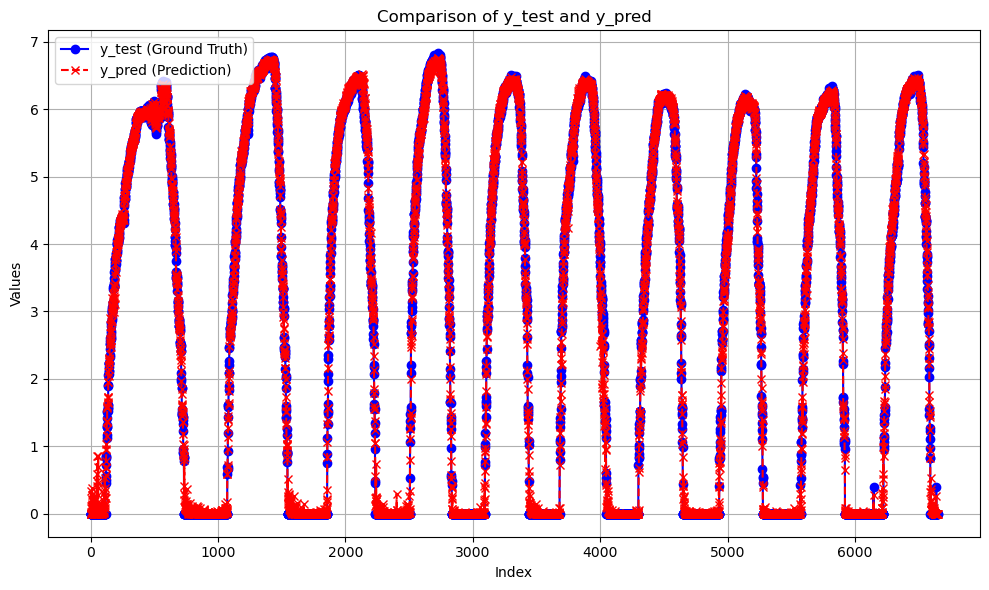

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
import glob

is_windowed = True #@param{type: "boolean"}
window_size = 10 #@param
is_normalization = False #@param{type: "boolean"}
def normalize2(raw_data):

  mean = np.mean(raw_data, axis=0)
  std = np.std(raw_data, axis=0)
  normalized_data = (raw_data - mean) / (std + 1e-6)
  return normalized_data

# Function to create windowed data
def create_windowed_data2(X, y, window_size=10):
    num_samples = X.shape[0] - window_size + 1  # Number of windows we can create
    print(num_samples)
    print(X)
    windowed_X = np.array([(normalize2(X[i:i + window_size]) if is_normalization else X[i:i + window_size]) for i in range(num_samples)])
    print(windowed_X)
    windowed_y = np.array([np.mean(y[i + window_size - 1]) for i in range(num_samples)])  # target at the end of the window
    # should delete
    # unnormalize_windowed_X = np.array([( X[i:i + window_size]) for i in range(num_samples)])
    # print(windowed_X[2000])
    # print(unnormalize_windowed_X[2000])
    return windowed_X, windowed_y

def load_and_preprocess_data(data_path):
    data = None
    labels = None
    users = []
    sessions = []
    # Walk through the folder structure
    for participant_folder in os.listdir(data_path):
      
      participant_path = os.path.join(data_path, participant_folder)
      if not os.path.isdir(participant_path):
        continue
      user = os.path.basename(participant_path)
      if ('p38' not in user):
        continue
      # for session_id in ['1', '2', '3']:
      for session_id in ['1']:
        file_pattern = os.path.join(participant_path, f'*-{session_id}.npy')
        real = np.array([])
        imag = np.array([])
        force = np.array([])
        print(file_pattern)
        for file in glob.glob(file_pattern):
          if 'real' in file:
            with open(file, 'rb') as f:
              real = np.load(f)
          elif 'imag' in file:
            with open(file, 'rb') as f:
              imag = np.load(f)
          elif 'force' in file:
            with open(file, 'rb') as f:
              force = np.load(f)
        num_entries = real.shape[0]
        new_data = np.concatenate([real, imag], axis=1)
        new_force = force
        
        if is_windowed:
          new_data, new_force = create_windowed_data1(new_data, force, window_size=window_size)
          original_data = new_data
        if data is not None:
          data = np.append(data, new_data, axis=0)
        else:
          data = new_data
        labels = np.append(labels, new_force, axis=0) if labels is not None else new_force
        users.extend([user] * new_data.shape[0])
        sessions.extend([session_id] * num_entries)
    return original_data,data, labels, np.array(users), np.array(sessions)

# Path to the extracted dataset
data_path = '/home/ubuntu/paper_arm_model/EIT_Model_Input_Resource/pinch-pressure/batch-2/#processed-data'
model_file_path = '/home/ubuntu/paper_arm_model/best_model/best_rf_model.joblib'
model = joblib.load(model_file_path)
# Load and preprocess the data
original_data_d,X_test, y_test, users, sessions = load_and_preprocess_data(data_path)

print(X_test.shape)
print(y_test.shape)
# label_set = np.unique(labels)
print(np.unique(users))
print(np.unique(sessions))
if len(X_test.shape) > 2:
    X_test = X_test.reshape(X_test.shape[0], window_size * 12)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)
print(r2)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='y_test (Ground Truth)', marker='o', linestyle='-', color='blue')
plt.plot(y_pred, label='y_pred (Prediction)', marker='x', linestyle='--', color='red')


plt.title('Comparison of y_test and y_pred')
plt.xlabel('Index')
plt.ylabel('Values')


plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()


# Predict specific data

In [63]:
import os

# Folder path
# directory = "/home/ubuntu/paper_arm_model/best_model/true_y"
directory = "/home/ubuntu/paper_arm_model/best_model/true_y_window40"
# Create an empty dictionary to store the results
file_dict = {}

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".h5"):
        # Extract pxx as the key
        key = filename.split('_')[0]
        # Construct the full file path
        path = os.path.join(directory, filename)
        # Add the key and path to the dictionary
        file_dict[key] = path

# Print the dictionary content
file_dict



{'p39': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p39_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p41': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p41_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p37': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p37_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p40': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p40_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p28': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p28_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p25': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p25_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p27': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p27_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p32': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p32_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p33': '/home/u

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
import glob

is_windowed = True #@param{type: "boolean"}
window_size = 10 #@param
is_normalization = False #@param{type: "boolean"}
def normalize(raw_data):

  mean = np.mean(raw_data, axis=0)
  std = np.std(raw_data, axis=0)
  normalized_data = (raw_data - mean) / (std + 1e-6)
  return normalized_data

# Function to create windowed data
def create_windowed_data(X, y, window_size=10):
    num_samples = X.shape[0] - window_size + 1  # Number of windows we can create
    windowed_X = np.array([(normalize(X[i:i + window_size]) if is_normalization else X[i:i + window_size]) for i in range(num_samples)])
    max_y = max(np.max(y), 1e-6)
    windowed_y = np.array([np.mean(y[i + window_size - 1])/max_y if is_y_percentage else np.mean(y[i + window_size - 1]) for i in range(num_samples)])  # target at the end of the window
    return windowed_X, windowed_y, max_y

def load_and_preprocess_data(data_path):
    data = None
    labels = None
    users = []
    sessions = []
    # Walk through the folder structure
    for participant_folder in os.listdir(data_path):
      
      participant_path = os.path.join(data_path, participant_folder)
      if not os.path.isdir(participant_path):
        continue
      user = os.path.basename(participant_path)
      if ('p25' not in user):
        continue
      # for session_id in ['1', '2', '3']:
      for session_id in ['1']:
        file_pattern = os.path.join(participant_path, f'*-{session_id}.npy')
        real = np.array([])
        imag = np.array([])
        force = np.array([])
        print(file_pattern)
        for file in glob.glob(file_pattern):
          if 'real' in file:
            with open(file, 'rb') as f:
              real = np.load(f)
          elif 'imag' in file:
            with open(file, 'rb') as f:
              imag = np.load(f)
          elif 'force' in file:
            with open(file, 'rb') as f:
              force = np.load(f)
        num_entries = real.shape[0]
        new_data = np.concatenate([real, imag], axis=1)
        new_force = force
        
        if is_windowed:
          new_data, new_force = create_windowed_data(new_data, force, window_size=window_size)
          original_data = new_data
        if data is not None:
          data = np.append(data, new_data, axis=0)
        else:
          data = new_data
        labels = np.append(labels, new_force, axis=0) if labels is not None else new_force
        users.extend([user] * new_data.shape[0])
        sessions.extend([session_id] * num_entries)
    return original_data,data, labels, np.array(users), np.array(sessions)


/home/ubuntu/paper_arm_model/best_model/true_y/p38_cnn_true_y_regresser_best_model.h5
/home/ubuntu/paper_arm_model/EIT_Model_Input_Resource/pinch-pressure/batch-2/#processed-data/p25/*-1.npy
(7341, 10, 12)
(7341,)
['p25']
['1']
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


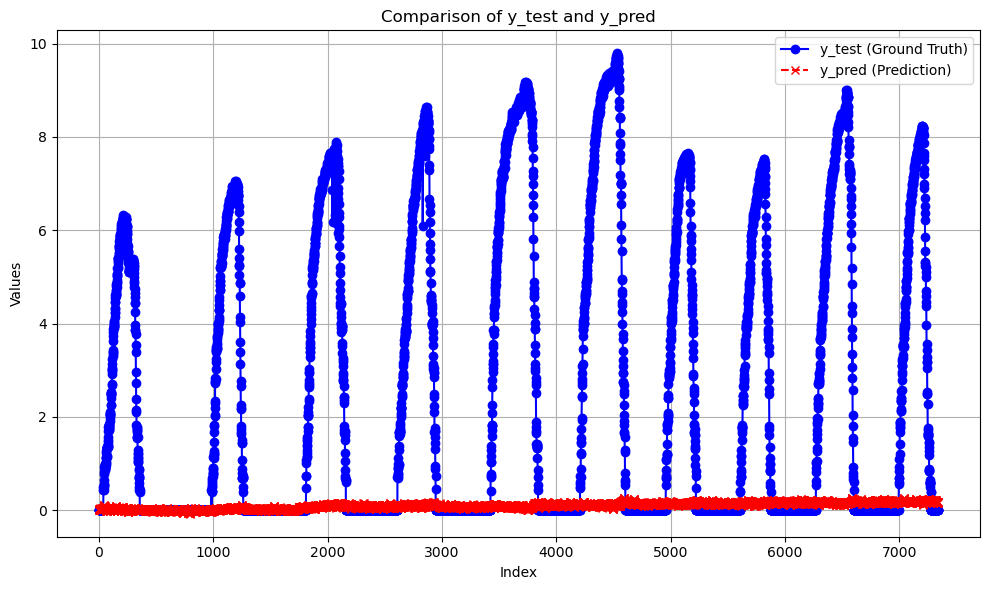

In [30]:
from tensorflow.keras.models import load_model


# Path to the extracted dataset
data_path = '/home/ubuntu/paper_arm_model/EIT_Model_Input_Resource/pinch-pressure/batch-2/#processed-data'

# Load and preprocess the data
for user, model_file_path in file_dict.items():
    print(model_file_path)
    model = load_model(model_file_path, custom_objects={'mse': 'mse'})

    original_data_d,X_test, y_test, users, sessions = load_and_preprocess_data(data_path)

    print(X_test.shape)
    print(y_test.shape)
    # label_set = np.unique(labels)
    print(np.unique(users))
    print(np.unique(sessions))
    # if len(X_test.shape) > 2:
    #     X_test = X_test.reshape(X_test.shape[0], window_size * 12)
    y_pred = model.predict(X_test)
    # mse = mean_squared_error(y_test, y_pred)
    # r2 = r2_score(y_test, y_pred)
    # print(mse)
    # print(r2)

    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='y_test (Ground Truth)', marker='o', linestyle='-', color='blue')
    plt.plot(y_pred, label='y_pred (Prediction)', marker='x', linestyle='--', color='red')


    plt.title('Comparison of y_test and y_pred')
    plt.xlabel('Index')
    plt.ylabel('Values')


    plt.legend()


    plt.grid(True)
    plt.tight_layout()
    plt.show()
    break


# google_code 2


In [79]:
import os

# Folder path
# directory = "/home/ubuntu/paper_arm_model/best_model/true_y"
directory = "/home/ubuntu/paper_arm_model/best_model/true_y_window40"
# Create an empty dictionary to store the results
file_dict = {}

# Iterate through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".h5"):
        # Extract pxx as the key
        key = filename.split('_')[0]
        # Construct the full file path
        path = os.path.join(directory, filename)
        # Add the key and path to the dictionary
        file_dict[key] = path

# Print the dictionary content
file_dict



{'p39': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p39_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p41': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p41_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p37': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p37_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p40': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p40_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p28': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p28_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p25': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p25_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p27': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p27_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p32': '/home/ubuntu/paper_arm_model/best_model/true_y_window40/p32_cnn_percentage_y_LOSO_fs_10_regresser_best_model.h5',
 'p33': '/home/u

In [76]:
#@title Preparing Data

import os
import numpy as np
from sklearn.model_selection import train_test_split

is_windowed = True #@param{type: "boolean"}
window_size = 40 #@param
is_normalization = False #@param{type: "boolean"}
exclusion_list = ['p24', 'p26', 'p36'] #@param
inclusion_list = ['p38'] #@param
is_inclusion = True #@param{type: "boolean"}
is_y_percentage = False #@param{type: "boolean"}

def normalize(raw_data):
  mean = np.mean(raw_data, axis=0)
  std = np.std(raw_data, axis=0)
  normalized_data = (raw_data - mean) / (std + 1e-6)
  return normalized_data


# Function to create windowed data
def create_windowed_data(X, y, window_size=10):
    num_samples = X.shape[0] - window_size + 1  # Number of windows we can create
    windowed_X = np.array([(normalize(X[i:i + window_size]) if is_normalization else X[i:i + window_size]) for i in range(num_samples)])
    max_y = max(np.max(y), 1e-6)
    windowed_y = np.array([np.mean(y[i + window_size - 1])/max_y if is_y_percentage else np.mean(y[i + window_size - 1]) for i in range(num_samples)])  # target at the end of the window
    return windowed_X, windowed_y, max_y


def load_and_preprocess_data(data_path):
    {('p25', '1'): 9.79, ('p25', '2'): 8.21, ('p25', '3'): 9.54, ('p27', '1'): 11.19, ('p27', '2'): 10.87, ('p27', '3'): 10.87, ('p28', '1'): 10.31, ('p28', '2'): 10.5, ('p28', '3'): 12.31, ('p29', '1'): 10.15, ('p29', '2'): 9.56, ('p29', '3'): 9.62, ('p30', '1'): 10.37, ('p30', '2'): 9.68, ('p30', '3'): 9.37, ('p31', '1'): 10.84, ('p31', '2'): 10.4, ('p31', '3'): 10.06, ('p32', '1'): 9.59, ('p32', '2'): 10.0, ('p32', '3'): 10.22, ('p33', '1'): 10.27, ('p33', '2'): 8.65, ('p33', '3'): 8.97, ('p34', '1'): 11.15, ('p34', '2'): 9.88, ('p34', '3'): 11.49, ('p35', '1'): 10.95, ('p35', '2'): 10.77, ('p35', '3'): 11.81, ('p37', '1'): 5.82, ('p37', '2'): 5.75, ('p37', '3'): 5.41, ('p38', '1'): 6.83, ('p38', '2'): 7.25, ('p38', '3'): 6.73, ('p39', '1'): 11.4, ('p39', '2'): 9.34, ('p39', '3'): 12.35, ('p40', '1'): 12.49, ('p40', '2'): 11.57, ('p40', '3'): 11.23, ('p41', '1'): 12.35, ('p41', '2'): 11.89, ('p41', '3'): 12.67}
    data = None
    labels = None
    users = []
    sessions = []
    max_force_dict = {}
    # Walk through the folder structure
    for participant_folder in os.listdir(data_path):
      participant_path = os.path.join(data_path, participant_folder)
      user = os.path.basename(participant_path)
      if is_inclusion and user not in inclusion_list:
        continue
      if (user in exclusion_list):
        continue
      # for session_id in ['1', '2', '3']:
      for session_id in ['1']:
        file_pattern = os.path.join(participant_path, f'*-{session_id}.npy')
        real = np.array([])
        imag = np.array([])
        force = np.array([])
        for file in glob.glob(file_pattern):
          if 'real' in file:
            with open(file, 'rb') as f:
              real = np.load(f)
          elif 'imag' in file:
            with open(file, 'rb') as f:
              imag = np.load(f)
          elif 'force' in file:
            with open(file, 'rb') as f:
              force = np.load(f)
        num_entries = real.shape[0]
        new_data = np.concatenate([real, imag], axis=1)
        new_force = force
        max_force = 0
        if is_windowed:
          new_data, new_force, max_force = create_windowed_data(new_data, force, window_size=window_size)
        if data is not None:
          data = np.append(data, new_data, axis=0)
        else:
          data = new_data
        labels = np.append(labels, new_force, axis=0) if labels is not None else new_force
        users.extend([user] * new_data.shape[0])
        sessions.extend([session_id] * num_entries)
        max_force_dict[(user, session_id)] = max_force

    return data, labels, np.array(users), np.array(sessions), max_force_dict

# Path to the extracted dataset
data_path = '/home/ubuntu/paper_arm_model/EIT_Model_Input_Resource/pinch-pressure/batch-2/#processed-data'
print(os.listdir(data_path))
# Load and preprocess the data
data, labels, users, sessions, max_force_dict = load_and_preprocess_data(data_path)
# data_new, labels_new, _, _ = load_and_preprocess_data(data_path)

print(data.shape)
print(labels.shape)
print(max_force_dict)

# label_set = np.unique(labels)
print(np.unique(users))
print(np.unique(sessions))

['p30', 'p32', 'p31', 'p41', 'p37', 'p33', 'p36', 'p25', 'p29', 'p38', 'p24', 'p40', 'p34', 'p28', 'p26', 'p27', 'p39', 'p35']
(6618, 40, 12)
(6618,)
{('p38', '1'): 6.83}
['p38']
['1']


In [77]:
for user, model_file_path in file_dict.items():
    print(user)
    print(model_file_path)
    model = load_model(model_file_path, custom_objects={'mse': 'mse'})
    y_pred = model.predict(data)
    break

p38
/home/ubuntu/paper_arm_model/best_model/true_y/p38_cnn_true_y_regresser_best_model.h5


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


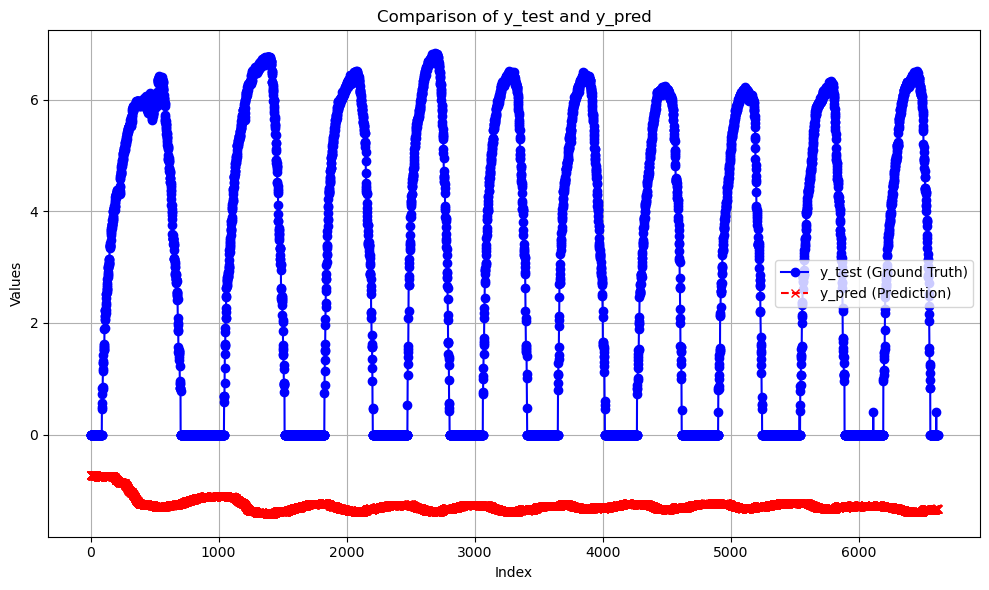

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(labels, label='y_test (Ground Truth)', marker='o', linestyle='-', color='blue')
plt.plot(y_pred, label='y_pred (Prediction)', marker='x', linestyle='--', color='red')


plt.title('Comparison of y_test and y_pred')
plt.xlabel('Index')
plt.ylabel('Values')


plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()

